# Exercise: Visualizing Sales Performance Data

In [2]:
!apt-get install openjdk-11-jdk -qq > /dev/null
!pip install pyspark==3.5.1 -q


1. Load the dataset into a PySpark DataFrame and display the first 10 rows.

In [3]:

from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, DateType
from pyspark.sql import functions as F
from datetime import date
import matplotlib.pyplot as plt
import pandas as pd
import os

spark = SparkSession.builder.getOrCreate()

schema = StructType([
    StructField("order_id", StringType()),
    StructField("region", StringType()),
    StructField("category", StringType()),
    StructField("quantity", IntegerType()),
    StructField("price", DoubleType()),
    StructField("order_date", DateType())
])

data = [
    ("O001", "South", "Electronics", 3, 15000.0, date(2025, 1, 5)),
    ("O002", "North", "Clothing", 5, 2000.0, date(2025, 1, 6)),
    ("O003", "East", "Furniture", 2, 12000.0, date(2025, 1, 7)),
    ("O004", "West", "Electronics", 1, 18000.0, date(2025, 1, 8)),
    ("O005", "North", "Furniture", 4, 9000.0, date(2025, 1, 10)),
    ("O006", "South", "Clothing", 6, 2500.0, date(2025, 1, 11)),
    ("O007", "East", "Electronics", 2, 17000.0, date(2025, 1, 12)),
    ("O008", "South", "Furniture", 5, 8500.0, date(2025, 1, 15)),
    ("O009", "West", "Clothing", 7, 3000.0, date(2025, 1, 17)),
    ("O010", "North", "Electronics", 4, 16000.0, date(2025, 1, 18))
]

df = spark.createDataFrame(data, schema)
df.show(10, False)

# Create folder for saving PNGs
save_path = "/dbfs/FileStore/tables/sales_viz/"
os.makedirs(save_path, exist_ok=True)


+--------+------+-----------+--------+-------+----------+
|order_id|region|category   |quantity|price  |order_date|
+--------+------+-----------+--------+-------+----------+
|O001    |South |Electronics|3       |15000.0|2025-01-05|
|O002    |North |Clothing   |5       |2000.0 |2025-01-06|
|O003    |East  |Furniture  |2       |12000.0|2025-01-07|
|O004    |West  |Electronics|1       |18000.0|2025-01-08|
|O005    |North |Furniture  |4       |9000.0 |2025-01-10|
|O006    |South |Clothing   |6       |2500.0 |2025-01-11|
|O007    |East  |Electronics|2       |17000.0|2025-01-12|
|O008    |South |Furniture  |5       |8500.0 |2025-01-15|
|O009    |West  |Clothing   |7       |3000.0 |2025-01-17|
|O010    |North |Electronics|4       |16000.0|2025-01-18|
+--------+------+-----------+--------+-------+----------+



2. Create a new column revenue = quantity × price .

In [4]:
from pyspark.sql.functions import col

df = df.withColumn("revenue", col("quantity") * col("price"))
df.show()


+--------+------+-----------+--------+-------+----------+-------+
|order_id|region|   category|quantity|  price|order_date|revenue|
+--------+------+-----------+--------+-------+----------+-------+
|    O001| South|Electronics|       3|15000.0|2025-01-05|45000.0|
|    O002| North|   Clothing|       5| 2000.0|2025-01-06|10000.0|
|    O003|  East|  Furniture|       2|12000.0|2025-01-07|24000.0|
|    O004|  West|Electronics|       1|18000.0|2025-01-08|18000.0|
|    O005| North|  Furniture|       4| 9000.0|2025-01-10|36000.0|
|    O006| South|   Clothing|       6| 2500.0|2025-01-11|15000.0|
|    O007|  East|Electronics|       2|17000.0|2025-01-12|34000.0|
|    O008| South|  Furniture|       5| 8500.0|2025-01-15|42500.0|
|    O009|  West|   Clothing|       7| 3000.0|2025-01-17|21000.0|
|    O010| North|Electronics|       4|16000.0|2025-01-18|64000.0|
+--------+------+-----------+--------+-------+----------+-------+



3. Generate a bar chart showing total revenue by category.

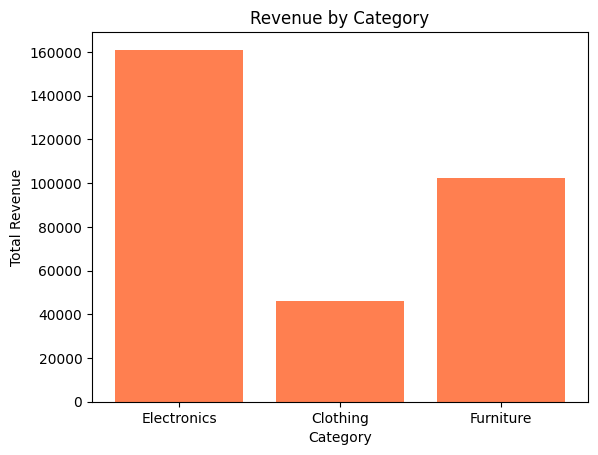

In [5]:
from pyspark.sql.functions import sum as _sum
import matplotlib.pyplot as plt
import pandas as pd
import os

save_path = "/dbfs/FileStore/tables/sales_viz/"
os.makedirs(save_path, exist_ok=True)

category_rev = df.groupBy("category").agg(_sum("revenue").alias("total_revenue")).toPandas()

plt.bar(category_rev["category"], category_rev["total_revenue"], color="coral")
plt.xlabel("Category")
plt.ylabel("Total Revenue")
plt.title("Revenue by Category")
plt.savefig(f"{save_path}01_revenue_by_category.png")
plt.show()


4. Create a line chart showing revenue trend by order_date (sorted by date).

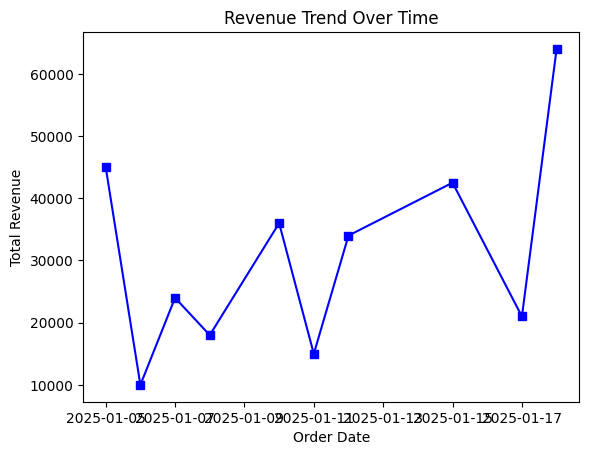

In [6]:
date_rev = df.groupBy("order_date").agg(_sum("revenue").alias("total_revenue")).orderBy("order_date").toPandas()

plt.plot(date_rev["order_date"], date_rev["total_revenue"], marker="s", color="blue")
plt.xlabel("Order Date")
plt.ylabel("Total Revenue")
plt.title("Revenue Trend Over Time")
plt.savefig(f"{save_path}02_revenue_trend.png")
plt.show()


5. Create a pie chart showing percentage contribution of each region to total
revenue.

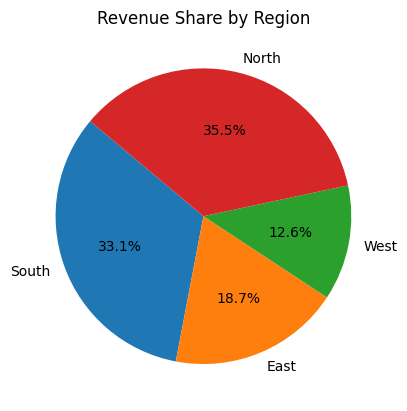

In [7]:
region_rev = df.groupBy("region").agg(_sum("revenue").alias("total_revenue")).toPandas()

plt.pie(region_rev["total_revenue"], labels=region_rev["region"], autopct="%1.1f%%", startangle=140)
plt.title("Revenue Share by Region")
plt.savefig(f"{save_path}03_revenue_share_region.png")
plt.show()


6. Create a stacked bar chart comparing total quantity sold per category by
region.

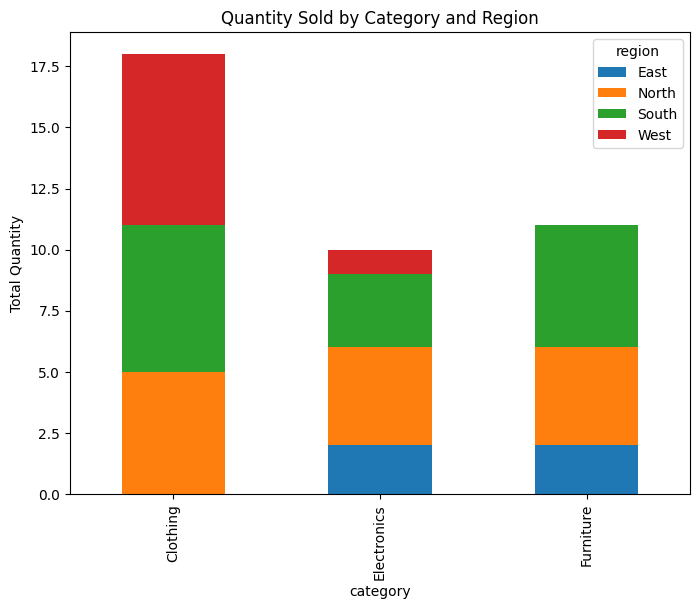

In [8]:
stack_data = df.groupBy("category", "region").agg(_sum("quantity").alias("total_quantity")).toPandas()
pivot_df = stack_data.pivot(index="category", columns="region", values="total_quantity").fillna(0)

pivot_df.plot(kind="bar", stacked=True, figsize=(8,6))
plt.ylabel("Total Quantity")
plt.title("Quantity Sold by Category and Region")
plt.savefig(f"{save_path}04_stacked_quantity.png")
plt.show()


7. Filter and visualize only top 5 products by total revenue in a horizontal bar
chart.

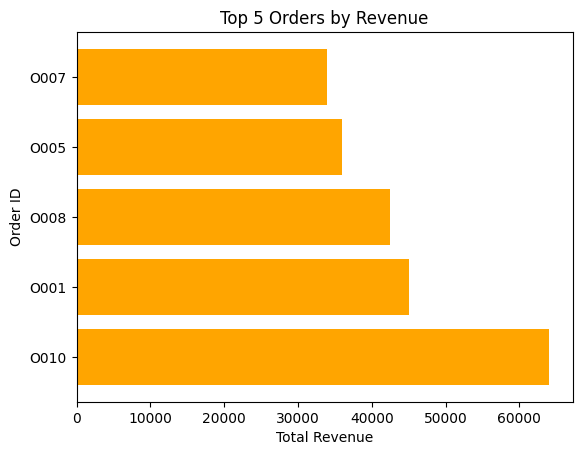

In [9]:
top5 = df.groupBy("order_id").agg(_sum("revenue").alias("total_revenue")).orderBy(col("total_revenue").desc()).limit(5).toPandas()

plt.barh(top5["order_id"], top5["total_revenue"], color="orange")
plt.xlabel("Total Revenue")
plt.ylabel("Order ID")
plt.title("Top 5 Orders by Revenue")
plt.savefig(f"{save_path}05_top5_orders.png")
plt.show()


8. Create a scatter plot showing quantity vs price colored by category .

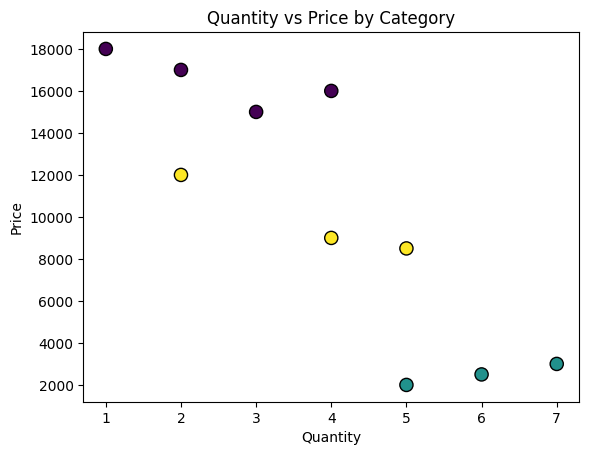

In [10]:
pdf = df.toPandas()
plt.scatter(pdf["quantity"], pdf["price"], c=pd.factorize(pdf["category"])[0], cmap="viridis", s=90, edgecolors="black")
plt.xlabel("Quantity")
plt.ylabel("Price")
plt.title("Quantity vs Price by Category")
plt.savefig(f"{save_path}06_scatter_quantity_price.png")
plt.show()


9. Find average order value by region and plot it as a bar chart.

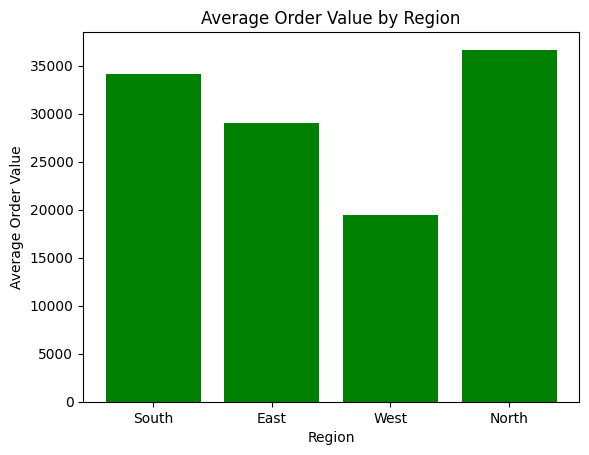

In [11]:
from pyspark.sql.functions import avg

avg_val = df.groupBy("region").agg(avg("revenue").alias("avg_order_value")).toPandas()

plt.bar(avg_val["region"], avg_val["avg_order_value"], color="green")
plt.xlabel("Region")
plt.ylabel("Average Order Value")
plt.title("Average Order Value by Region")
plt.savefig(f"{save_path}07_avg_order_value.png")
plt.show()


10. Create a heatmap (pivot table in Databricks) showing revenue by region and
category.

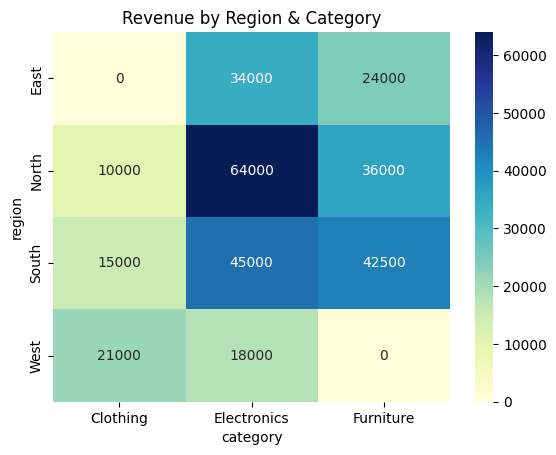

In [12]:
import seaborn as sns

heatmap_data = df.groupBy("region", "category").agg(_sum("revenue").alias("total_revenue")).toPandas()
pivot_hm = heatmap_data.pivot(index="region", columns="category", values="total_revenue").fillna(0)

sns.heatmap(pivot_hm, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Revenue by Region & Category")
plt.savefig(f"{save_path}08_heatmap_revenue.png")
plt.show()


11. Bonus: Apply a discount column:
Electronics → 10% discount
Clothing → 5% discount
Furniture → 8% discount Plot discounted vs original revenue for each category
in a grouped bar chart.

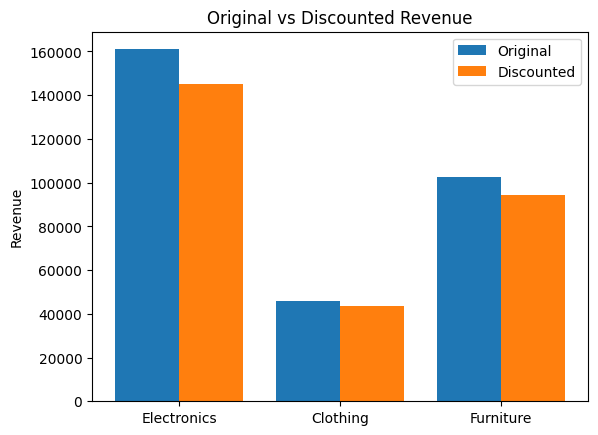

In [13]:
discounts = {"Electronics": 0.10, "Clothing": 0.05, "Furniture": 0.08}
from pyspark.sql.types import DoubleType
from pyspark.sql import functions as F

discount_udf = F.udf(lambda cat, rev: float(rev) * (1 - discounts.get(cat, 0)), DoubleType())

df = df.withColumn("discounted_revenue", discount_udf(col("category"), col("revenue")))

disc_summary = df.groupBy("category").agg(
    _sum("revenue").alias("original"),
    _sum("discounted_revenue").alias("discounted")
).toPandas()

x = range(len(disc_summary))
plt.bar(x, disc_summary["original"], width=0.4, label="Original")
plt.bar([i+0.4 for i in x], disc_summary["discounted"], width=0.4, label="Discounted")
plt.xticks([i+0.2 for i in x], disc_summary["category"])
plt.ylabel("Revenue")
plt.title("Original vs Discounted Revenue")
plt.legend()
plt.savefig(f"{save_path}09_discount_vs_original.png")
plt.show()


12. Save all visualizations as PNG files to /dbfs/FileStore/tables/sales_viz/ .

In [16]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.image as mpimg

pdf_path = "/content/sales_viz_charts.pdf"
with PdfPages(pdf_path) as pdf_all:
    for file in sorted(os.listdir(save_path)):
        if file.endswith(".png"):
            img = mpimg.imread(os.path.join(save_path, file))
            plt.imshow(img)
            plt.axis('off')
            pdf_all.savefig()
            plt.close()

print(f"All charts saved to {save_path}")
print(f"PDF created at {pdf_path}")


All charts saved to /dbfs/FileStore/tables/sales_viz/
PDF created at /content/sales_viz_charts.pdf
